## Bayesian parameter estimation using Importance Sampling

In this notebook we illustrate another way to sample from a posterior pdf, that is, using importance sampling. One samples from a proposal distribution, then the samples are weighted to account for the discrepancy between the proposal pdf and the target posterior pdf. The BayesParameterEstimation class using IS returns samples from the proposal and weigths for each sample. If one requires a set of un-weighted samples, one can use the resample function from UQpy.Utilities. This notebook also illustrates the use of simple diagnostics for IS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.inference import DistributionModel, BayesParameterEstimation, ComputationalModel
from UQpy.RunModel import RunModel  # required to run the quadratic model
from sklearn.neighbors import KernelDensity  # for the plots
from UQpy.distributions import JointIndependent, Uniform, Lognormal, Normal
from UQpy.sampling import ISInput

In [2]:
def pdf_from_kde(domain, samples1d):
    bandwidth = 1.06 * np.std(samples1d) * samples1d.size ** (-1 / 5)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples1d.reshape((-1, 1)))
    log_dens = kde.score_samples(domain)
    return np.exp(log_dens)

## Probability model

In the following we learn the mean and covariance of a univariate gaussian distribution from data.

First, for the sake of this example, we generate fake data from a gaussian distribution with mean 10 and standard deviation 1.

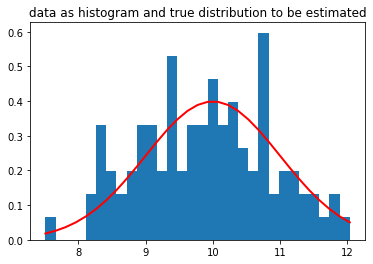

In [3]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters,
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1  # true mean and standard deviation
data = np.random.normal(mu, sigma, 100).reshape((-1, 1))
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [4]:
p0 = Uniform(loc=0., scale=15)
p1 = Lognormal(s=1., loc=0., scale=1.)
prior = JointIndependent(marginals=[p0, p1])

# create an instance of class Model
candidate_model = DistributionModel(distributions=Normal(loc=None, scale=None), parameters_number=2, prior=prior)

Learn the unknown parameters using IS. If no proposal is given, the samples are sampled from the prior.

In [5]:
bayes_estimator = \
    BayesParameterEstimation.create_with_importance_sampling(inference_model=candidate_model,
                                                             data=data,
                                                             is_input=ISInput(),
                                                             samples_number=50000)

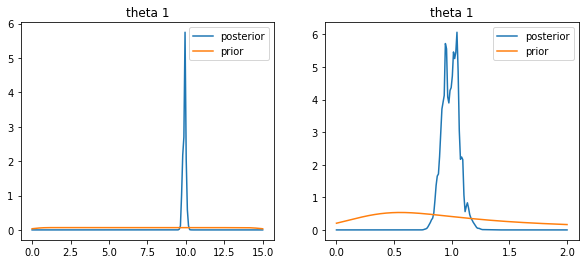

In [6]:
s_prior = bayes_estimator.sampler.samples
bayes_estimator.sampler.resample()
s_posterior = bayes_estimator.sampler.unweighted_samples

# print results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s_posterior[:, 0])
ax[0].plot(domain, pdf_, label='posterior')
pdf_ = pdf_from_kde(domain, s_prior[:, 0])
ax[0].plot(domain, pdf_, label='prior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s_posterior[:, 1])
ax[1].plot(domain, pdf_, label='posterior')
pdf_ = pdf_from_kde(domain, s_prior[:, 1])
ax[1].plot(domain, pdf_, label='prior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [7]:
param_true = np.array([1.0, 2.0]).reshape((1, -1))
print('Shape of true parameter vector: {}'.format(param_true.shape))

h_func = RunModel(model_script='pfn_models.py', model_object_name='model_quadratic', vec=False,
                  var_names=['theta_0', 'theta_1'])
h_func.run(samples=param_true)

# Add noise
error_covariance = 1.
data_clean = np.array(h_func.qoi_list[0])
noise = Normal(loc=0., scale=np.sqrt(error_covariance)).rvs(nsamples=50).reshape((50,))
data_3 = data_clean + noise
print('Shape of data: {}'.format(data_3.shape))

Shape of true parameter vector: (1, 2)
Shape of data: (50,)


In [8]:
inference_model = ComputationalModel(parameters_number=2, runmodel_object=h_func, error_covariance=error_covariance)

In [9]:
is_input1 = ISInput()
is_input1.proposal=JointIndependent([Normal(scale=2, )] * 2)
bayes_estimator =\
    BayesParameterEstimation.create_with_importance_sampling(inference_model=inference_model,
                                                             data=data_3,
                                                             is_input=is_input1,
                                                             samples_number=20000)

1.0


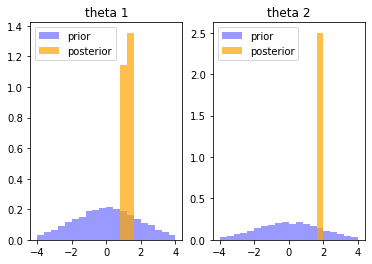

In [10]:
s = bayes_estimator.sampler.samples
w = bayes_estimator.sampler.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].hist(x=s[:, i], weights=None, density=True, range=(-4, 4), bins=20, color='blue', alpha=0.4,
               label='prior')
    ax[i].hist(x=s[:, i], weights=w, density=True, range=(-4, 4), bins=20, color='orange', alpha=0.7,
               label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i + 1))

plt.show()